# Projects: Advanced Sentiment Analysis with GRU & Attention

## # NLP Option: Advanced Sentiment Analysis with Attention
###  **Dataset**: **Twitter** US Airline Sentiment

   >**Why it's perfect**: It's real-world, messy, imbalanced, and has three classes (Positive,
 Neutral, Negative), making it more challenging than binary sentiment.
 
  >**Source**: Kaggle: Twitter US Airline Sentiment

## Step-by-Step Execution:
 
 ### 1. Problem Definition & Data Exploration:
 
 * **Frame the problem**: Multi-class classification (Negative, Neutral, Positive).
 * **Perform extensive Exploratory Data Analysis (EDA)**:

    *  Class distribution (plot a bar chart). You'll find it's imbalanced (more negatives).
    * Analyze text length (calculate mean, max, min words per tweet).
    * Look at common words for each sentiment using word clouds or frequency plots.
    * Identify any data quality issues (e.g., URLs, @mentions, emojis).
 
 ### 2. Data Preprocessing:
 * **Cleaning**: Lowercase all text, remove URLs, user mentions, and punctuation.
 * **Handling Emojis**: Consider converting emojis to text (e.g., ":)" to "happy_emoji") as they
 carry strong sentiment.
 * **Tokenization**: Use Keras's Tokenizer to split text into words and convert them to
 integers.
 * **Padding**: Pad sequences to a fixed length (determined from your EDA of text length) using
 pad_sequences .
 ### 3. Baseline Model (Simple Model for Comparison):
 * **Model**: A simple model without recurrent layers.
 
   > * Input Layer -> Embedding Layer -> GlobalAveragePooling1D() (or Flatten() ) ->   Dense layers -> Output Layer (softmax)
 * **Purpose**: This model establishes a performance baseline. Your advanced model must
 significantly outperform this to prove its value.
 * **Train & Evaluate**: Record accuracy, precision, recall, F1-score (crucial for imbalanced data).
 ### 4. Advanced Model (LSTM/GRU with Attention Mechanism):
 #### # Model Architecture:
 1. **Input Layer**: Takes the padded sequences.
 2. **Embedding Layer**: Converts integer sequences into dense word vectors. You can start
 with random initialization and later try pre-trained embeddings (like GloVe).
 3. **SpatialDropout1D**: Drops entire 1D feature maps to prevent overfitting on the
 embedding layer.
 4. **Bidirectional LSTM/GRU Layer**: This processes the sequence forwards and backwards,
 capturing more context than a unidirectional layer.
 
 5. **Attention Layer (The Key Differentiator)**: This is the advanced part. Instead of using
 just the last hidden state, the attention layer learns to "pay attention" to the most
 important words in the tweet for determining sentiment. (You will need to implement
 this yourself; it's a great talking point. Code is readily available for Keras/TensorFlow).
 6. **Dense Output Layer**: With 3 units and a softmax activation.
 #### Train & Evaluate: Compare metrics directly against your baseline. The attention model
 should have a higher F1-score.
 ### 5. Analysis and Comparison:
 * Create a table comparing the **Accuracy** and **F1-Score (macro-average)** of both models.
 * **Visualize Attention**: For a few sample tweets, create a visualization that highlights the
 words your model attended to the most. This proves the model is working intuitively and
 is a fantastic showcase of your deep understanding.
 * **Conclusion**: "The LSTM model with an attention mechanism outperformed the simple
 baseline by X%, demonstrating its ability to capture long-range contextual dependencies
 and focus on sentiment-carrying words.

### Import dependencis

In [44]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (GRU, Dense, Embedding, Bidirectional, GlobalAveragePooling1D,
Dropout, Input)

from tensorflow.keras.utils import to_categorical

### --- 1. Load and Explore Data ---

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


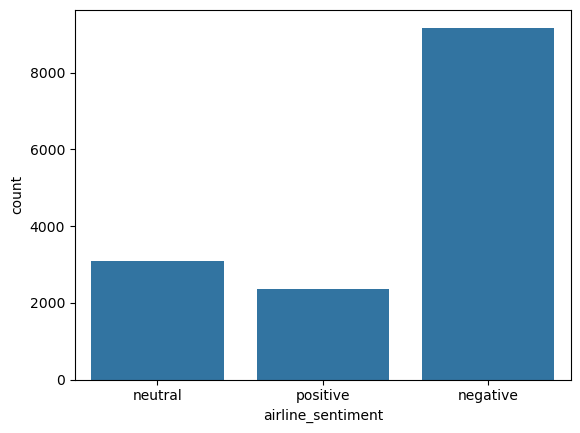

In [45]:
df = pd.read_csv(r"C:\Coding_language\Dataset\extracted_files\Tweets.csv") # Load dataset
print(df['airline_sentiment'].value_counts())
sns.countplot(x = 'airline_sentiment', data=df)
plt.show()

In [14]:
# Distribution graphs of column data
def column_distribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes
    nRow, nCol = df.shape
    col_names = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi =80, facecolor ='w', edgecolor='k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        col_df = df.iloc[:, i]
        if (not np.issubdtype(type(col_df.iloc[0]), np.number)):
            val_counts = col_df.value_counts()
            val_counts.plot.bar()
        else:
            col_df.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{col_names[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

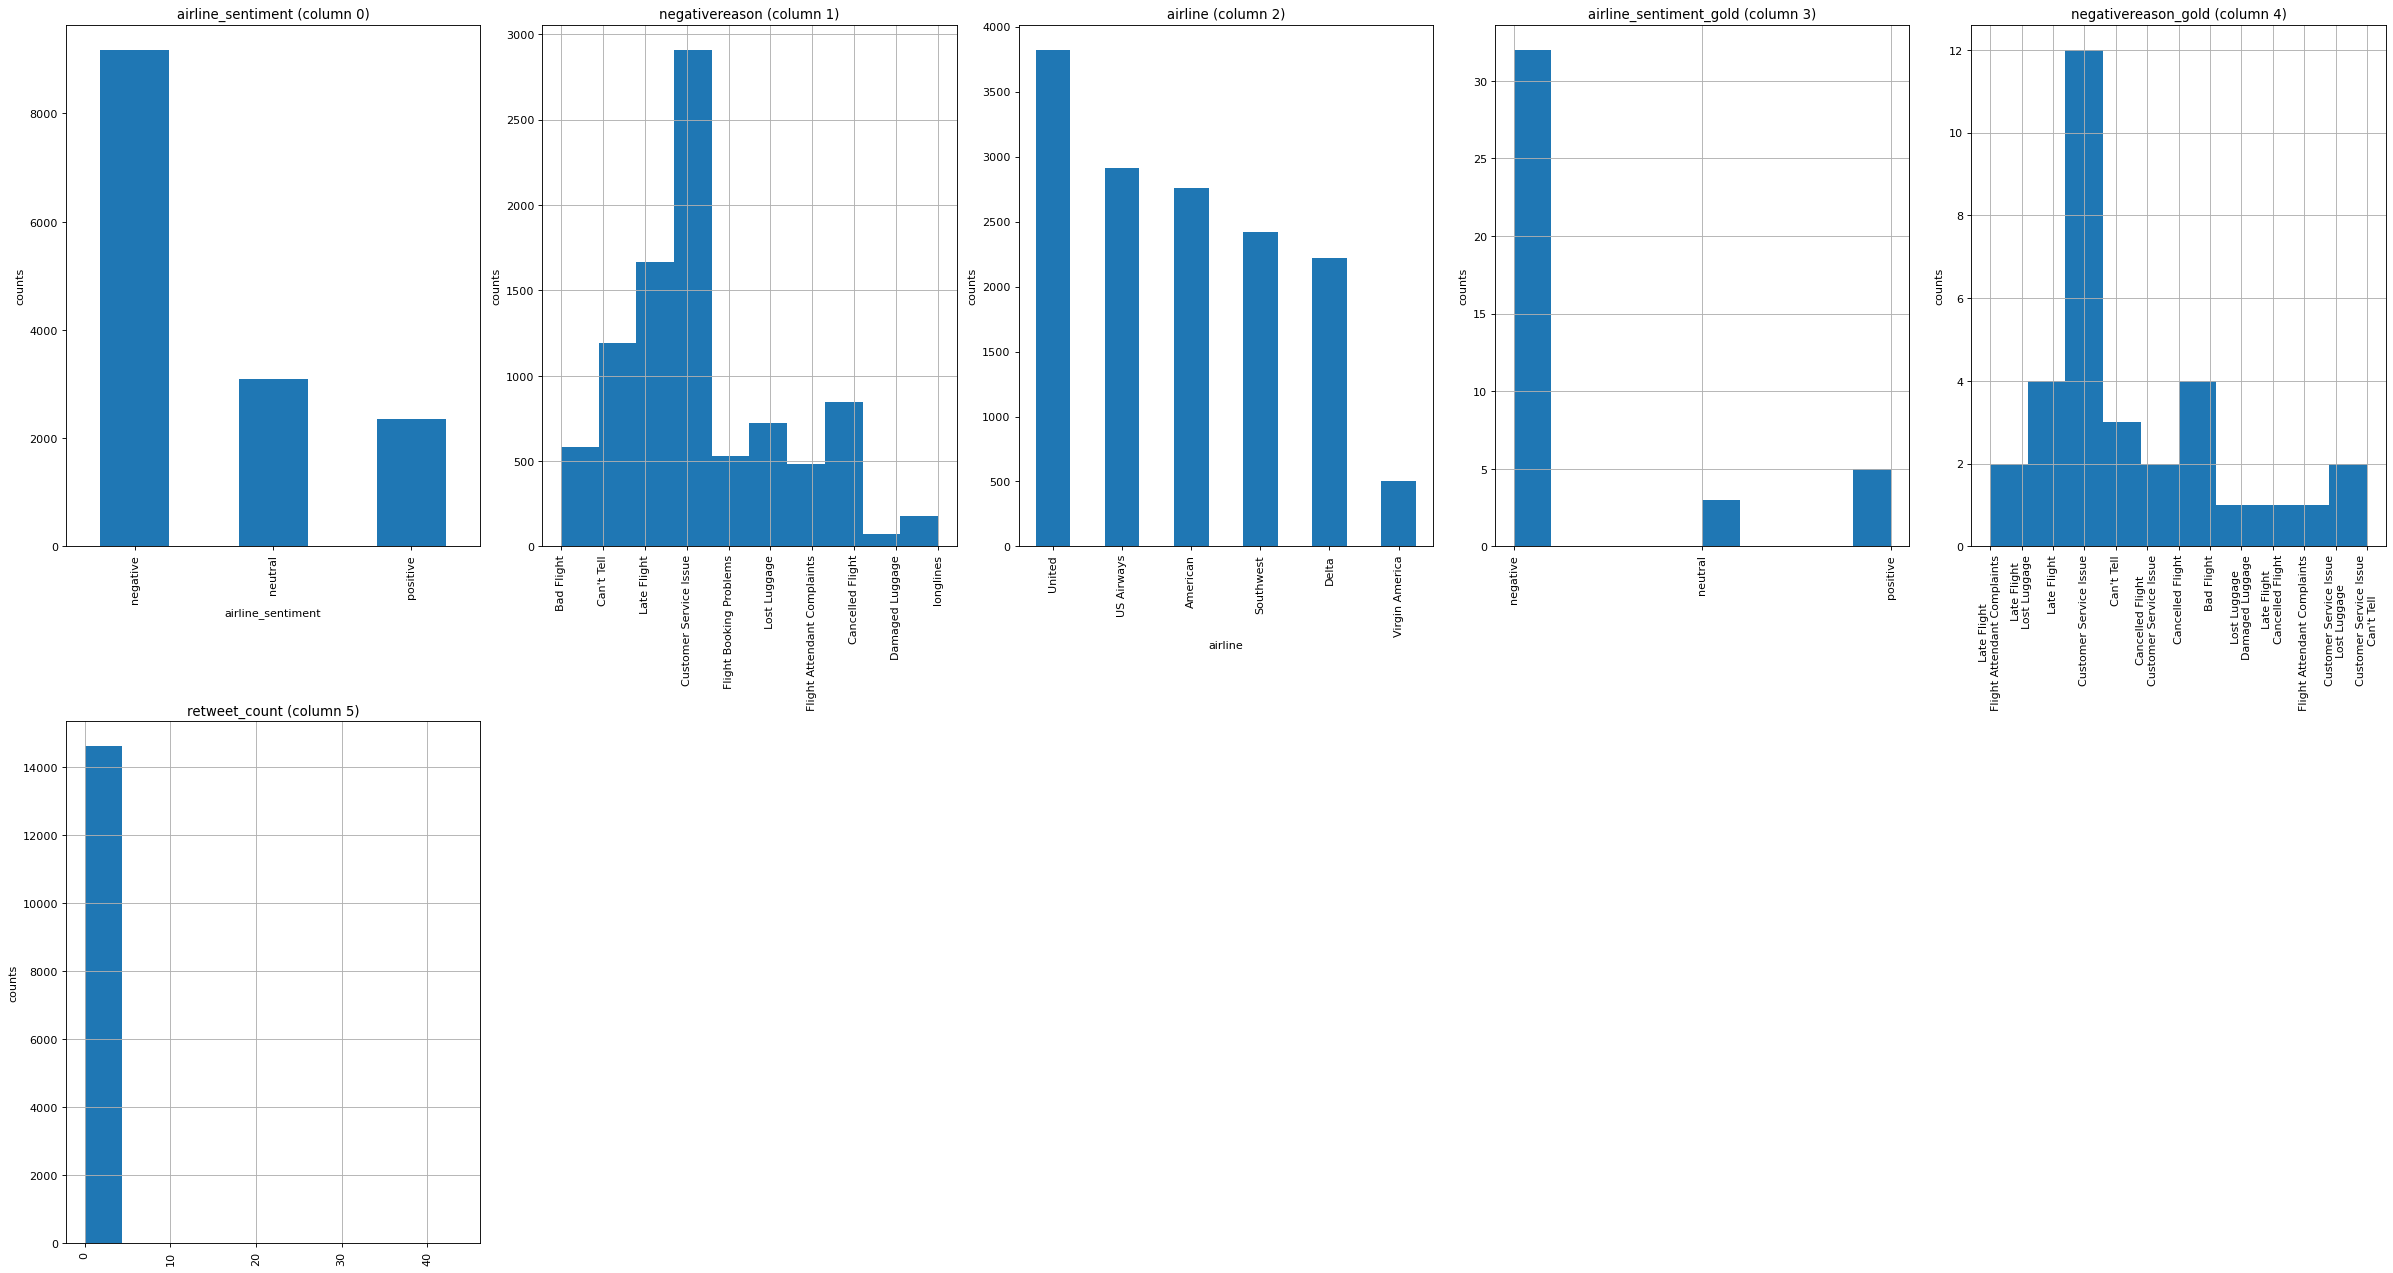

In [46]:
column_distribution(df, 10, 5)

### --- 2. Preprocessing ---

In [47]:
# Select text & label columns
tweets = df[['text', 'airline_sentiment']]
# Convert labels to categorical
sent_int = {'negative': 0, 'neutral': 1, 'positive': 2} # Sentiment to integer
tweets["labels"] = tweets['airline_sentiment'].map(sent_int)

C:\Users\SOHAM PORIA\AppData\Local\Temp\ipykernel_9700\1666390951.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets["labels"] = tweets['airline_sentiment'].map(sent_int)


In [48]:
# Basic text cleaning
def clean_text(text):
    text = text.lower() # For Lower case
    text = re.sub(r'http\S+', '', text) # remove URLs
    text = re.sub(r'@\w+', '', text) # remove mentions
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    return text


In [49]:
tweets['clean_text'] = tweets['text'].apply(clean_text)

C:\Users\SOHAM PORIA\AppData\Local\Temp\ipykernel_9700\37236362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['clean_text'] = tweets['text'].apply(clean_text)


In [50]:
# Tokenization and Sequencing
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(tweets['clean_text'])

sequences = tokenizer.texts_to_sequences(tweets['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=50, truncating='post')

In [51]:
 # Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, tweets['labels'], 
                                            test_size=0.2, random_state=42, stratify=tweets['labels'])

### Convert labels to one-hot encoding

In [52]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

### --- 3. Build a Baseline (Simple) Model ---

In [55]:
baseline_model = Sequential([
    Embedding(10000, 16, input_length = 50),
    GlobalAveragePooling1D(),
    Dense(24, activation = 'relu'),
    Dropout(0.25),
    Dense(3, activation = 'softmax') # 3 output neurons for 3 classes
])

baseline_model.compile(loss = 'categorical_crossentropy',
                        optimizer = 'adam',
                        metrics = ['accuracy'])

baseline_history = baseline_model.fit(X_train, y_train_cat,
                   epochs = 20,
                   validation_data = (X_test, y_test_cat),
                   batch_size = 32,
                   verbose = 1)

Epoch 1/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6004 - loss: 0.9884 - val_accuracy: 0.6267 - val_loss: 0.8630
Epoch 2/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6449 - loss: 0.8247 - val_accuracy: 0.7046 - val_loss: 0.7345
Epoch 3/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6952 - loss: 0.7086 - val_accuracy: 0.7264 - val_loss: 0.6645
Epoch 4/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7496 - loss: 0.6063 - val_accuracy: 0.7818 - val_loss: 0.5927
Epoch 5/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7968 - loss: 0.5228 - val_accuracy: 0.7896 - val_loss: 0.5479
Epoch 6/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8168 - loss: 0.4797 - val_accuracy: 0.7865 - val_loss: 0.5316
Epoch 7/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8364 - loss: 0.4370 - val_accuracy: 0.7968 - val_loss: 0.5221
Epoch 8/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8530 - loss: 0.3967 - val_accuracy: 0

### --- 4. Build Advanced Model (Bidirectional GRU with Attention) ---

In [56]:
print('\n--- Building and Training Advanced GRU Model with Attention ---')

# Define Attention layer
class Attention_Layer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention_Layer, self).__init__(**kwargs) # The Constructor

    def build(self, input_shape):
        self.W = self.add_weight(name = 'att_weight', shape = (input_shape[-1], 1), initializer = 'normal')
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention_Layer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.activations.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.keras.activations.softmax(e, axis = 1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# Model using the Attention layer with GRU
gru_input = Input(shape = (50,))
x = Embedding(10000, 128)(gru_input)
x = Bidirectional(GRU(64, return_sequences = True))(x) # return_sequences is CRITICAL for Attention
x = Attention_Layer()(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.3)(x)
gru_output = Dense(3, activation = 'softmax')(x)

adv_model = Model(inputs = gru_input, outputs = gru_output)
adv_model.compile(loss='categorical_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])
adv_model.summary()


--- Building and Training Advanced GRU Model with Attention ---


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_7 (Embedding)              │ (None, 50, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 50, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention__layer_2 (Attention_Layer) │ (None, 128)                 │             178 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,363,125 (5.20 MB)

 Trainable params: 1,363,125 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
adv_history = adv_model.fit(X_train, y_train_cat, epochs = 20,
                           validation_data = (X_test, y_test_cat),
                           verbose = 1, batch_size = 32)

Epoch 1/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - accuracy: 0.6244 - loss: 0.9678 - val_accuracy: 0.6267 - val_loss: 0.9164
Epoch 2/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.6282 - loss: 0.9163 - val_accuracy: 0.6267 - val_loss: 0.9085
Epoch 3/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6256 - loss: 0.9114 - val_accuracy: 0.6267 - val_loss: 0.8981
Epoch 4/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.6237 - loss: 0.8993 - val_accuracy: 0.6267 - val_loss: 0.8830
Epoch 5/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6223 - loss: 0.8884 - val_accuracy: 0.6267 - val_loss: 0.8638
Epoch 6/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6256 - loss: 0.8643 - val_accuracy: 0.6332 - val_loss: 0.8456
Epoch 7/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.6335 - loss: 0.8458 - val_accuracy: 0.6475 - val_loss: 0.8382
Epoch 8/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6390 - loss: 0.8417 - 

### --- 5. Compare Results ---


 --- Comparing Model Performance---


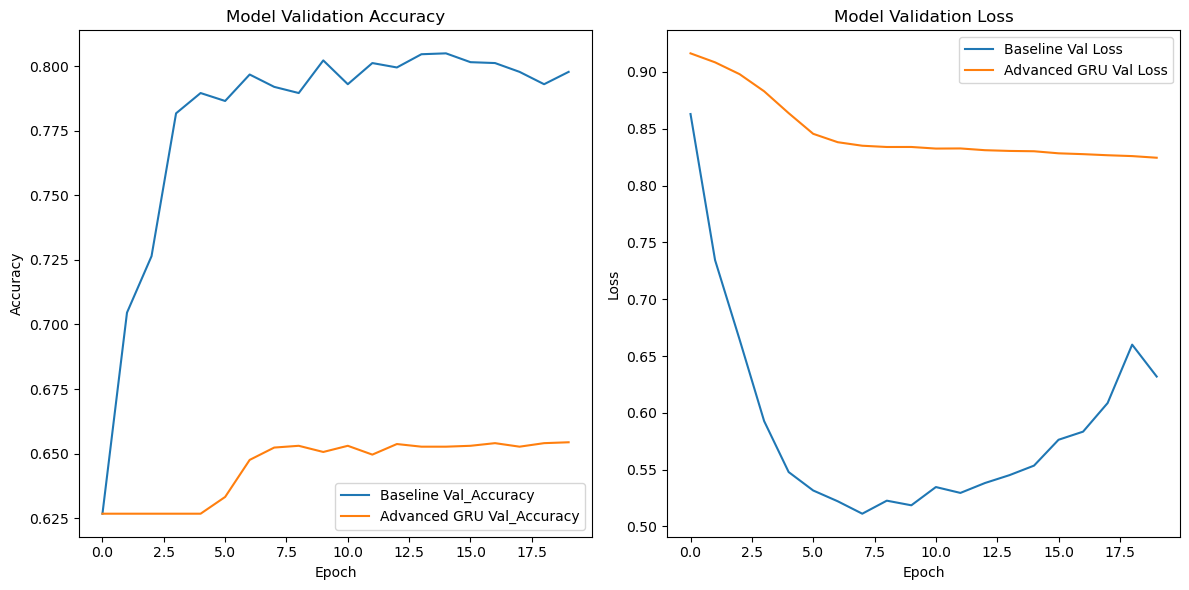

In [60]:
print('\n --- Comparing Model Performance---')
# Plot accuracy history
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(baseline_history.history['val_accuracy'], label = 'Baseline Val_Accuracy')
plt.plot(adv_history.history['val_accuracy'], label = 'Advanced GRU Val_Accuracy')
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot loss history
plt.subplot(122)
plt.plot(baseline_history.history['val_loss'], label='Baseline Val Loss')
plt.plot(adv_history.history['val_loss'], label='Advanced GRU Val Loss')
plt.title('Model Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

#### # Get Final metrics (Prediction)

In [62]:
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(X_test, y_test_cat, verbose=0)
adv_test_loss, adv_test_acc = adv_model.evaluate(X_test, y_test_cat, verbose=0)

print(f"Baseline Model Test Accuracy: {baseline_test_acc:.4f}")
print(f"Advanced GRU Model Test Accuracy: {adv_test_acc:.4f}")

Baseline Model Test Accuracy: 0.7978
Advanced GRU Model Test Accuracy: 0.6544


### --Generate classification report--

In [66]:
print("\nGenerating predictions and classification reports ---")
y_pred_baseline = np.argmax(baseline_model.predict(X_test), axis=1)
y_pred_advanced = np.argmax(adv_model.predict(X_test), axis=1)

print("\nBaseline Model Classification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=sent_int.keys()))

print("\nAdvanced GRU Model Classification Report:")
print(classification_report(y_test, y_pred_advanced, target_names=sent_int.keys()))


Generating predictions and classification reports ---
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

Baseline Model Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.90      0.87      1835
     neutral       0.66      0.58      0.62       620
    positive       0.74      0.69      0.72       473

    accuracy                           0.80      2928
   macro avg       0.75      0.72      0.74      2928
weighted avg       0.79      0.80      0.79      2928


Advanced GRU Model Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.95      0.80      1835
     neutral       0.44      0.29      0.35       620
    positive       0.00      0.00      0.00       473

    accuracy                           0.65      2928
   macro avg       0.38      0.41      0.38      2928
weighted avg       0.53      0.65      0.57      2928



C:\Users\SOHAM PORIA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SOHAM PORIA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SOHAM PORIA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Confusion Matrix

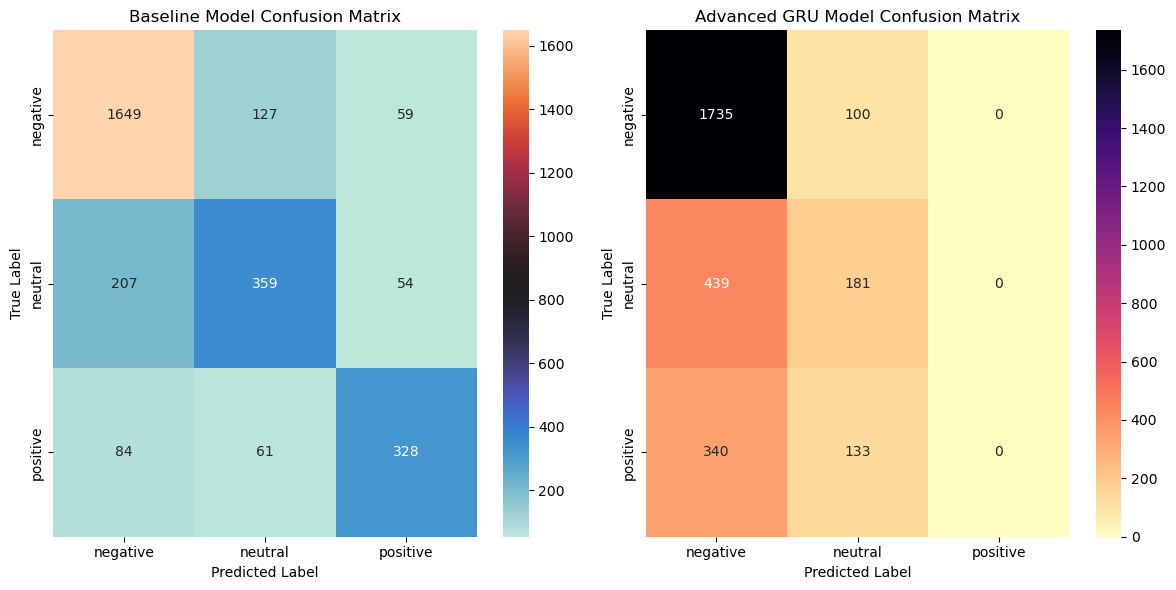

In [78]:
plt.figure(figsize= (12,6))
plt.subplot(121)
sns.heatmap(confusion_matrix(y_test, y_pred_baseline), annot=True, fmt='d', cmap='icefire',
            xticklabels=sent_int.keys(), yticklabels=sent_int.keys())  # 'viridis', 'cividis', 'twilight', 'twilight_shifted','YlOrRd_r', 'afmhot_r'
plt.title('Baseline Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


plt.subplot(122)
sns.heatmap(confusion_matrix(y_test, y_pred_advanced), annot=True, fmt='d', cmap='magma_r', xticklabels = sent_int.keys(),
              yticklabels = sent_int.keys()) # 'ocean_r', 'pink_r', 'prism_r', 'rainbow_r','vlag', 'vlag_r', 'flare', 'flare_r', 'crest', 'crest_r'
plt.title('Advanced GRU Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()